## Tensorflow

In [71]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

tf.__version__

'2.3.0'

In [72]:
fashion_mnist = tf.keras.datasets.fashion_mnist

(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

print(X_train.shape, y_train.shape)

(60000, 28, 28) (60000,)


In [73]:
X_train = X_train.reshape((len(X_train), -1))
X_test = X_test.reshape((len(X_test), -1))

X_train = np.asarray(X_train, dtype=np.float32)
X_test = np.asarray(X_test, dtype=np.float32)

y_train = np.asarray(y_train, dtype=np.int32)
y_test = np.asarray(y_test, dtype=np.int32)

epochs = 100

print(X_train.shape, y_train.shape)

(60000, 784) (60000,)


In [74]:
from sklearn import preprocessing

scaler = preprocessing.StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test) # Center and Normalize

In [75]:
def one_hot(num_classes, y):
    return np.eye(num_classes)[y]

# Acurracy
def accuracy(y_pred, y_true):
    return np.mean(y_pred == y_true)

In [76]:
class NeuralNet:
    def __init__(self, input_shape):
        initializer = tf.keras.initializers.GlorotUniform()
        
        self.w1 = tf.Variable(initializer(shape=(input_shape, 50)))
        self.b1 = tf.Variable(tf.zeros([50]))
        
        self.w2 = tf.Variable(initializer(shape=(50, 10)))
        self.b2 = tf.Variable(tf.zeros([10]))
        
    def __call__(self, inputs):
        return self.forward(inputs)
    
    def forward(self, inputs):
        z1 = tf.matmul(inputs, self.w1) + self.b1
        a1 = tf.keras.activations.relu(z1)
        
        z2 = tf.matmul(z1, self.w2) + self.b2
        a2 = tf.keras.activations.softmax(z2)
        
        return a2
    
    def train(self, X_train, y_train,
             epochs=10,
             batch_size = 32):
        # Batch dataset
        dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
        dataset = dataset.shuffle(buffer_size=10000, seed=42)
        dataset = dataset.batch(batch_size=batch_size)
        # Loss Function
        loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
        # Optimizer
        optimizer = tf.keras.optimizers.Adam()
        
        losses = []
        
        for e in range(epochs):
            for (inputs, targets) in dataset:
                targets = one_hot(10, targets)
                with tf.GradientTape() as tape:
                    output = self.forward(inputs)
                    loss = loss_fn(output, targets)
                    losses.append(loss)
                variables = [self.w1, self.b1, self.w2, self.b2]
                grads = tape.gradient(loss, variables)
                optimizer.apply_gradients(zip(grads, variables))
        return losses

0.8436
CPU times: user 19min 35s, sys: 44.1 s, total: 20min 19s
Wall time: 16min 43s


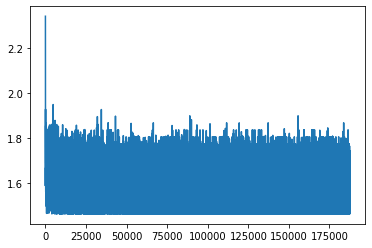

In [77]:
%%time

model = NeuralNet(X_train.shape[1])
losses = model.train(X_train, y_train, epochs)

pred_y = model.forward(X_test)
pred_y = np.argmax(pred_y, axis=1)
print(accuracy(pred_y, y_test))

plt.plot(losses)

## Keras

In [78]:
%%time

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(50, input_dim=X_train.shape[1], activation='relu'))
model.add(tf.keras.layers.Dense(10, activation='softmax'))
model.compile(optimizer='adam',
             loss=tf.keras.losses.SparseCategoricalCrossentropy(),
             metrics=['accuracy'])

model.fit(X_train, y_train, validation_split=0.2, epochs=epochs, verbose=False)
pred_y = model.predict(X_test)
pred_y = np.argmax(pred_y, axis=1)
cluster data into k clusters
print(accuracy(pred_y, y_test))

0.8678
CPU times: user 4min 43s, sys: 36.8 s, total: 5min 20s
Wall time: 2min 1s


In [79]:
pred_y = model.predict(X_test)
pred_y = np.argmax(pred_y, axis=1)

print(accuracy(pred_y, y_test))

0.8678


## PyTorch

In [80]:
import torch
from torch.utils.data import DataLoader

In [81]:
def gen_dataset(x, y, batch_size=32):
    train_data = []
    for i in range(len(x)):
        train_data.append([x[i], y[i]])
    return DataLoader(train_data, batch_size=batch_size, shuffle=True)

In [82]:
%%time
model = torch.nn.Sequential(
    torch.nn.Linear(X_train.shape[1], 50),
    torch.nn.ReLU(),
    torch.nn.Linear(50, 10)
)

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001) # Keras lr
train_dl = gen_dataset(X_train, y_train)

for e in range(epochs):
    for (inputs, targets) in train_dl:
        y_pred = model(inputs)
        
        loss = loss_fn(y_pred, targets.type(torch.long))
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

CPU times: user 12min 12s, sys: 0 ns, total: 12min 12s
Wall time: 3min 3s


In [83]:
pred_y = torch.nn.Softmax(dim=1)(model(torch.tensor(X_test))).detach().numpy()
pred_y = np.argmax(pred_y, axis=1)

print(accuracy(pred_y, y_test))

0.8627


## Classic classifier

In [84]:
%%time
from sklearn.ensemble import RandomForestClassifier

rfm = RandomForestClassifier() # We don't tweak any values
rfm.fit(X_train, y_train)

pred_y = rfm.predict(X_test)
print(accuracy(pred_y, y_test)) 

0.8766
CPU times: user 1min 23s, sys: 0 ns, total: 1min 23s
Wall time: 1min 23s


In [85]:
%%time
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=10, random_state=0).fit(X_train)

pred_y = kmeans.predict(X_test)
print(accuracy(pred_y, y_test))

0.1754
CPU times: user 4min 12s, sys: 1min 42s, total: 5min 54s
Wall time: 47 s
